# LIME XAI Method Explanation

Here are the resources we used to implement the LIME method:
- https://www.kaggle.com/code/yohanb/explaining-keras-model-with-lime  

The Kaggle tutorial provided all the code we needed, making the implementation straightforward.

Start by importing the needed libraries:

In [1]:
from lime import lime_image
from PIL import Image
import numpy as np
from pathlib import Path
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Load a test image from the image dataset:

We select an image from the public samples and resize it to 224x224 pixels, converting it to RGB format to match the model's expected input.

In [3]:
true_label = "present"
img_test_path = next((Path(os.getcwd()).parent.parent / "frontend" / "public" / "image" / "present").iterdir())
img_array = np.array(Image.open(img_test_path).convert('RGB').resize((224, 224)))
img_array.shape

(224, 224, 3)

Load the preprocessing function for MobileNetV2:

This function will scale pixel values appropriately for the model when making predictions during LIME's perturbation process.

In [4]:
pre_process = tf.keras.applications.mobilenet_v2.preprocess_input

Initialize the LIME image explainer:

LIME uses a random seed for reproducibility. The explainer will segment the image into superpixels and test different combinations to identify which regions are most important for the prediction.

In [5]:
explainer = lime_image.LimeImageExplainer(random_state=42)

Load the fine-tuned classification model and define class names:

We load the MobileNetV2 model fine-tuned for multi-label chest X-ray classification. The class names array maps output indices to condition labels.

In [6]:
model_path = Path(os.getcwd()).parent.parent / "backend" / "models" / "image" / "mobilenet-v2" / "model.keras"
model = tf.keras.models.load_model(model_path)
class_names = [
    "No Finding",
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Opacity",
    "Lung Lesion",
    "Edema",
    "Consolidation",
    "Pneumonia",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Pleural Other",
    "Fracture",
    "Support Devices"
]

Generate a LIME explanation for the prediction:

This may take a moment. LIME creates 1000 perturbed versions of the image by turning superpixels on/off, then trains a local linear model to identify which regions most influence the prediction for the top 5 classes.

In [7]:
explanation = explainer.explain_instance(
    img_array, 
    classifier_fn=lambda x: model.predict(x, verbose=0), 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000
)

100%|██████████| 1000/1000 [00:40<00:00, 24.66it/s]


Extract the segmentation mask highlighting important regions:

We retrieve the top 10 superpixels that positively contributed to the prediction. The mask shows only these important regions while hiding the rest of the image.

In [8]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True
)

Visualize the original image and LIME explanation side by side:

The left panel shows the original image with its true label. The right panel displays the LIME explanation with boundaries highlighting the superpixels that contributed most to the model's prediction.

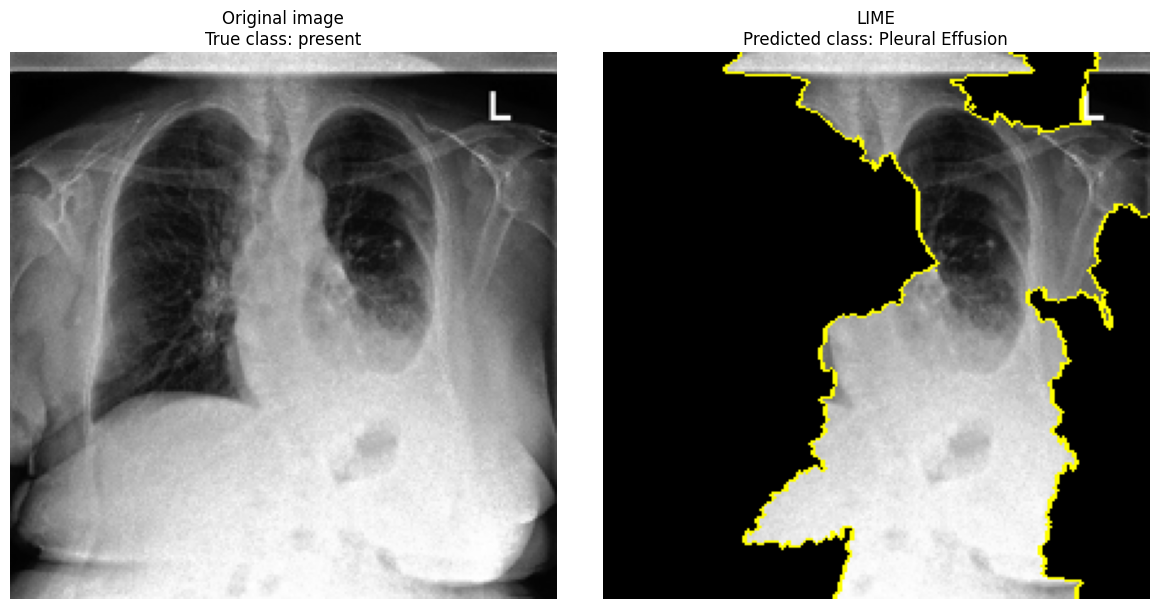

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img_array / 255.0)
ax1.set_title(f"Original image\nTrue class: {true_label}")
ax1.axis("off")

pred_idx = explanation.top_labels[0]
ax2.imshow(mark_boundaries(temp / 255.0, mask))
ax2.set_title(f"LIME\nPredicted class: {class_names[pred_idx]}")
ax2.axis("off")

plt.tight_layout()
plt.show()